# TP 2 - Grupo 7

André Filipe Dourado Pinheiro - A108473

Tiago Silva Costa - A108657

## Problema 2 - Control Flow Automaton

Usa-se um “Control Flow Automaton” como  modelo do programa imperativo que calcula a multiplicação de  inteiros positivos representados por vetores de bits.

O trabalho requer:
1. Construir um FOTS, usando BitVec’s de tamanho $n$ , que descreva o comportamento deste autómato; para isso identifique e codifique em `z3-solver`  ou `pySMT`, as variáveis do modelo, o estado inicial , a relação de transição e o estado de erro.
2. Usando Bounded Model Checking (BMC) verifique nesse SFOTS se a propriedade $\;(x*y + z = a*b)\;$ é um invariante do seu comportamento.
3. Sejam $\,N,M\,$ parâmetros do problema. Usando BMC em $N$ passos  no FOTS acima e adicionando a condição  $\,N \leq a,b \leq M\,$ ao estado inicial, verifique a segurança do programa; nomeadamente  verifique que, com tal estado inicial, o estado de erro não é acessível.



## Modelação

Com o objetivo de resolver o problema proposto, optou-se pela utilização do módulo `pysmt.shortcuts`, que oferece diversos recursos voltados ao uso de SMT Solvers. Além disso, os tipos de dados específicos do Solver são importados a partir do módulo `pysmt.typing`.

Como o modelo desenvolvido baseia-se em BitVectors, o solver escolhido foi o `z3`.

Por fim, vamos utilizar outros módulos para facilitar a visualização do FOTS.

In [1]:
from pysmt.shortcuts import *
import pysmt.typing as types

import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display

### Variáveis

Os *inputs* do nosso programa serão:

1. $n \in \mathbb{N}$ - número de bits da precisão de todas as variáveis do problema.
2. $a,b \in \mathbb{N}$ - os números que queremos multiplicar.



Além disso, vamos definir variáveis que serão usadas pelo modelo:

1. $x,y,z$ - que serão utilizadas pelo modelo para computar a multiplicação final.
2. $pc$ - representa o estado de execução, estes podem ser:
   - $0$ - Estado *skip*/inicial.
   - $1$ - Estado *left*.
   - $2$ - Estado *right*.
   - $3$ - Estado final de sucesso.
   - $-1$ - Estado de erro.

Dado que o resultado do produto de $a\times b$ pode exceder o limite de bits, uma vez que 

$$\log a \leq n \wedge \log b \leq n \implies \log (a \times b) \leq 2n$$

vamos definir o tamanho dos BitVectors como $2n$

In [2]:
n = 16

def declare(i):
    state = {}
    state['pc'] = Symbol('pc'+str(i),INT) 
    state['x'] = Symbol('x'+str(i),types.BVType(2*n)) 
    state['y'] = Symbol('y'+str(i),types.BVType(2*n))
    state['z'] = Symbol('z'+str(i),types.BVType(2*n))
    return state

### Implementação do autómato

#### Estado inicial

Começemos por introduzir uma otimização no processo de execução do autómato, que consiste em atribuir a $x$ o maior valor entre $a$ e $b$, e a $x$ o menor entre os mesmos. Isto permite evitar operações desnecessárias nos piores casos.

Sendo assim, temos o seguinte predicado:

$$ pc = 0 \wedge x = a \wedge y = b \wedge z = 0 \wedge x \leq y $$

Para implementar esse estado inical, iremos definir a função `init`. Esta recebe um parâmetro adicional que é o `bound`, que será posteriormente usado para verificar a segurança do programa, isto é, se caso seja fornecido o par $(N,M)$, será adicionada a restrição $N \leq a,b \leq M$.

Além disso, escolhemos fazer com que os valores de $a,b$ sejam aleatórios, pertecentes ao conjunto $\{0,1,\cdots, 2^n-1\}$.


In [3]:
def init(state, bound=None):
    init_constrains = And(Equals(state['pc'], Int(0)), BVULT(state['x'], BV(2**n, 2*n)), BVULT(state['y'], BV(2**n, 2*n)), Equals(state['z'],BVZero(2*n)), BVULT(state['y'], state['x']))
    if bound != None:
        init_constrains = And(init_constrains, 
                              BVUGE(state['x'], BV(bound[0], 2*n)), BVUGE(state['y'], BV(bound[0], 2*n)),
                              BVULE(state['x'], BV(bound[1], 2*n)), BVULE(state['y'], BV(bound[1], 2*n)))
    
    return init_constrains

#### Transições

Seja $x_i$ o bit na posição $i$ do BitVector $x$, que pode ser defenido pela seguinte função `lastBit`:

In [4]:
def lastBit(z,i):                    
    return BVExtract(z,start=i,end=i)



A relação de transição entre o estado $0$ e os estados $1,2,3$ é dado pelo seguinte predicado

\begin{array}{c}
(\mathit{pc} = 0 \wedge y_0 = 0 \wedge y \neq 0 \wedge \mathit{pc}' = 1 \wedge x' = x \wedge y' = y \wedge z' = z) \\
\vee\\
(\mathit{pc} = 0 \wedge y_0 = 1 \wedge \mathit{pc}' = 2 \wedge x' = x \wedge y' = y \wedge z' = z) \\
\vee\\
(\mathit{pc} = 0 \wedge y = 0 \wedge \mathit{pc}' = 3 \wedge x' = x \wedge y' = y \wedge z' = z)\\
\end{array}

Pois: 
1. A transição $0 \to 1$ ocorre apenas quando $y \equiv 0 \mod 2$ e $y \neq 0$, mais isso é equivalente ao bit menos significativo ser $0$, ou seja $y_0 = 0$.
2. De forma análoga, a transição $0 \to 2$ ocorre se $y \equiv 1 \mod 2 \Leftrightarrow y_0=1$.



A partir do estado $1$, temos dois cenários a considerar:

1. Transitar para o estado $0$ **se** $2x < 2^n$, isto é, se após a *shift* para à esquerda (pois $2x = x \ll 1$) não ocorre *overflow*. 
2. Transitar para o estado $-1$ caso contrário, pois nesse caso tem-se $x_{n-1}=1$, não é possível operar.

\begin{array}{c}
(\mathit{pc} = 1 \wedge (x \ll 1) < 2^n \wedge \mathit{pc}' = 0 \wedge x' = 2x \wedge y' = y/2 \wedge z' = z)\\
\vee\\
(\mathit{pc} = 1 \wedge x_{n-1}=1 \wedge \mathit{pc}' = -1 \wedge x' = x \wedge y' = y \wedge z' = z)\\
\end{array}


Analogamente, repete-se o mesmo raciocínio para o estado 2

\begin{array}{c}
(\mathit{pc} = 2 \wedge 2^n - 1 - z \geq x \wedge \mathit{pc}' = 0 \wedge x' = x \wedge y' = y - 1 \wedge z' = z + x)\\
\vee\\
(\mathit{pc} = 2 \wedge 2^n - 1 - z < x \wedge \mathit{pc}' = -1 \wedge x' = x \wedge y' = y \wedge z' = z)\\
\end{array}


Finalmente, caso os estados $-1$ ou $3$ sejam alcançados, criamos as seguintes transições para criar um *loop*, já que esses estados são finais.

\begin{array}{c}
(\mathit{pc} = -1 \wedge \mathit{pc}' = -1 \wedge x' = x \wedge y' = y \wedge z' = z)\\
\vee\\
(\mathit{pc} = 3 \wedge \mathit{pc}' = 3 \wedge x' = x \wedge y' = y \wedge z' = z)\\
\end{array}


In [5]:
def trans(curr, prox):
    zero_to_one = And(Equals(curr['pc'], Int(0)), Equals(prox['pc'], Int(1)), Not(Equals(curr['y'], BVZero(2*n))), Equals(lastBit(curr['y'],0), BVZero(1)),
                Equals(curr['x'], prox['x']), Equals(curr['y'], prox['y']), Equals(curr['z'], prox['z']))
    
    zero_to_two = And(Equals(curr['pc'], Int(0)), Equals(prox['pc'], Int(2)), Equals(lastBit(curr['y'],0), BVOne(1)),
               Equals(curr['x'], prox['x']), Equals(curr['y'], prox['y']), Equals(curr['z'], prox['z']))
    
    zero_to_three = And(Equals(curr['pc'], Int(0)), Equals(prox['pc'], Int(3)), Equals(curr['y'], BVZero(2*n)),
               Equals(curr['x'], prox['x']), Equals(curr['y'], prox['y']), Equals(curr['z'], prox['z']))
    


    one_to_zero = And(Equals(curr['pc'], Int(1)), Equals(prox['pc'], Int(0)), Equals(prox['x'], BVLShl(curr['x'], BVZExt(BVOne(1), 2*n-1))),
                 Equals(prox['y'], BVLShr(curr['y'], BVZExt(BVOne(1), 2*n-1))), Equals(curr['z'], prox['z']), Not(Equals(lastBit(curr['x'], n-1), BVOne(1))))
    
    one_to_error = And(Equals(curr['pc'], Int(1)), Equals(prox['pc'], Int(-1)), Equals(lastBit(curr['x'], n-1), BVOne(1)),
                  Equals(curr['x'], prox['x']), Equals(curr['y'], prox['y']), Equals(curr['z'], prox['z']))



    two_to_zero = And(Equals(curr['pc'], Int(2)), Equals(prox['pc'], Int(0)), Equals(prox['y'], curr['y'] - BVZExt(BVOne(1), 2*n-1)), 
                Equals(prox['z'], curr['z'] + curr['x']), Equals(prox['x'], curr['x']), Not(curr['x'] > BVSub(BV(2**n-1,2*n), curr['z'])))
    
    two_to_error = And(Equals(curr['pc'], Int(2)), Equals(prox['pc'], Int(-1)), curr['x'] > BVSub(BV(2**n-1,2*n), curr['z']),
                 Equals(curr['x'], prox['x']), Equals(curr['y'], prox['y']), Equals(curr['z'], prox['z']))
    


    three_to_three = And(Equals(curr['pc'], Int(3)), Equals(prox['pc'], Int(3)), 
                  Equals(curr['x'], prox['x']), Equals(curr['y'], prox['y']), Equals(curr['z'], prox['z']))

    error_to_error = And(Equals(curr['pc'], Int(-1)), Equals(prox['pc'], Int(-1)), 
               Equals(curr['x'], prox['x']), Equals(curr['y'], prox['y']), Equals(curr['z'], prox['z']))
    
    return Or(zero_to_one, zero_to_two, zero_to_three, two_to_zero, two_to_error, one_to_zero, one_to_error, three_to_three, error_to_error)

#### Ilustração

Para melhor visualização das transições que o FTOS faz, criamos as funções auxiliars:

1. `extract_path` - resposável por extrair as transições feitas no traço
2. `plot_FTOS` - responsável por fazer o plot do FTOS

In [6]:
def extract_path(path_states):
    path = []
    for i in range(len(path_states)-1):
        path.append((path_states[i], path_states[i+1]))

    return path

In [7]:
def plot_FTOS(track):
    G = nx.DiGraph()
    G.add_edges_from([("0", "1"), ("1", "0"), ("0", "2"), ("2", "0"), ("0","3"), ("1","-1"), ("2","-1"), ("-1", "-1"), ("3", "3")])
    pos = {"0": (0, 1), "1": (-1, 0),"2": (1, 0), "-1": (-0.5, -1), "3": (0.5, -1)}

    fig, ax = plt.subplots(figsize=(6, 4))
    def update(i):
        ax.clear()
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)

        nx.draw_networkx_edges(G, pos,edge_color='lightgray',arrows=True,arrowstyle='-|>',min_source_margin=15,min_target_margin=15,connectionstyle="arc3,rad=0.2",ax=ax)

        current_edge = [(track[i][0][0], track[i][1][0])]
        nx.draw_networkx_edges(G, pos,edgelist=current_edge,edge_color='red',width=2.5,arrows=True,arrowstyle='-|>',min_source_margin=15,min_target_margin=15,connectionstyle="arc3,rad=0.2",ax=ax)

        src, dst = track[i]
        ax.set_title(f"Transition {i}: \n (x: {src[1]}, y: {src[2]}, z: {src[3]}) → (x: {dst[1]}, y: {dst[2]}, z: {dst[3]})", fontsize=12)
        ax.axis("off")

    ani = FuncAnimation(fig, update, frames=len(track), interval=1000, repeat=True)
    gif_path = "cfa_animation.gif"
    ani.save(gif_path, writer="pillow", fps=1)
    plt.close(fig)
    
    display(Image(filename=gif_path))




#### Geração de traços

Com os estados e transições definidos e com as ferramentas de visualização, podemos criar a função de ordem superior `generate_track(declare,init,trans,k)` que gera um traço de tamanho $k$

(pc=0, x=4222_32, y=0_32, z=0_32)
(pc=3, x=4222_32, y=0_32, z=0_32)
(pc=3, x=4222_32, y=0_32, z=0_32)
(pc=3, x=4222_32, y=0_32, z=0_32)
(pc=3, x=4222_32, y=0_32, z=0_32)


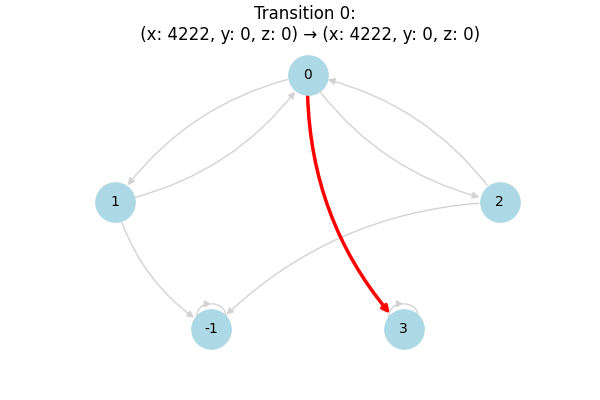

In [8]:
def generate_track(declare,init,trans,k):
    with Solver(name="z3") as s:

        states = [declare(i) for i in range(k)]
        constraints = []

        constraints.append(init(states[0]))
        for i in range(k-1):
            constraints.append(trans(states[i], states[i+1]))
        s.add_assertion(And(constraints))

        if s.solve():
            model = s.get_model()
            path_states = []
            for i,st in enumerate(states):
                value = [str(model.get_value(st[name])).split("_")[0] for name in ['pc', 'x', 'y', 'z']]
                path_states.append(value)
                print(f'(pc=%s, x=%s, y=%s, z=%s)' % (model.get_value(st['pc']), model.get_value(st['x']), model.get_value(st['y']), model.get_value(st['z'])))

            path = extract_path(path_states)
            plot_FTOS(path)
            
        else:
            print("Nenhum traço")

generate_track(declare,init,trans,5)

### Verificação do invariante

Queremos ver se a propriedade $\;(x*y + z = a*b)\;$ é um invariante. Para isso, vamos criar a função `inv` que descreve o predicado do invariante. 


In [9]:
def inv(state,a,b):
    return Equals(BVAdd(BVMul(state['x'], state['y']), state['z']), BVMul(a,b))

Em seguida, vamos criar uma função de ordem superior `bmc_always` para além de gerar um traço que verifica o input e condição `inv` em cada estado e retorna os tamanhos do traço em que essa propriedade é válida.

In [10]:
def bmc_always(declare,init,trans,inv,K):
    for k in range(1,K+1):
        with Solver(name="z3") as s:
            states = [declare(i) for i in range(k)]
            constraints = []

            constraints.append(init(states[0]))
            for i in range(k-1):
                constraints.append(trans(states[i], states[i+1]))

            for i in range(k):
                constraints.append(Not(inv(states[i], states[0]['x'], states[0]['y'])))

            s.add_assertion(And(constraints))

            if s.solve():
                model = s.get_model()
                path_states = []
                for i,st in enumerate(states):
                    value = [str(model.get_value(st[name])).split("_")[0] for name in ['pc', 'x', 'y', 'z']]
                    path_states.append(value)
                    print(f'(pc=%s, x=%s, y=%s, z=%s)' % (model.get_value(st['pc']), model.get_value(st['x']), model.get_value(st['y']), model.get_value(st['z'])))
                print("Propriedade violada neste caminho")
                path = extract_path(path_states)
                plot_FTOS(path)

                return
            
    print(f"Propriedade não é violada para traços até {k}.")   

        
bmc_always(declare,init,trans,inv,2*n)

Propriedade não é violada para traços até 32.


### Segurança do programa

Queremos agora utilizar BMC em $N$ passos no FOTS com a condição $\,N \leq a,b \leq M\,$ a mais no estado inicial e verificar se o estado de erro nunca é acessível.

Começemos por definir a função `error` que descreve o predicado do estado de erro ser atingido.

In [11]:
def error(state):
    return Equals(state['pc'], Int(-1))

Em seguida, vamos criar uma função de ordem superior `bmc_always_secure` que recebe os valores $N,M$ e verifica se há algum traço de tamanho $N$ para o qual é atingido o estado de erro. Caso não exista, significa que o programa é seguro.

In [12]:
def bmc_always_secure(declare,init,trans,error,N,M):
    with Solver(name="z3") as s:
        states = [declare(i) for i in range(N)]
        constraints = []

        constraints.append(init(states[0],(N,M)))
        for i in range(N-1):
            constraints.append(trans(states[i], states[i+1]))

        constraints.append(error(states[-1]))
        s.add_assertion(And(constraints))

        if s.solve():
            model = s.get_model()
            path_states = []
            for i,st in enumerate(states):
                value = [str(model.get_value(st[name])).split("_")[0] for name in ['pc', 'x', 'y', 'z']]
                path_states.append(value)
                print(f'(pc=%s, x=%s, y=%s, z=%s)' % (model.get_value(st['pc']), model.get_value(st['x']), model.get_value(st['y']), model.get_value(st['z'])))
            print("Contraexemplo encontrado")
            path = extract_path(path_states)
            plot_FTOS(path)

            return
            
    print(f"Nenhum contraexemplo encontrado entre {N} e {M}")     

        
bmc_always_secure(declare,init,trans,error,12,15)

Nenhum contraexemplo encontrado entre 12 e 15


## Testes

(pc=0, x=32840_32, y=0_32, z=0_32)
(pc=3, x=32840_32, y=0_32, z=0_32)
(pc=3, x=32840_32, y=0_32, z=0_32)
(pc=3, x=32840_32, y=0_32, z=0_32)
(pc=3, x=32840_32, y=0_32, z=0_32)
(pc=3, x=32840_32, y=0_32, z=0_32)
(pc=3, x=32840_32, y=0_32, z=0_32)
(pc=3, x=32840_32, y=0_32, z=0_32)
(pc=3, x=32840_32, y=0_32, z=0_32)
(pc=3, x=32840_32, y=0_32, z=0_32)


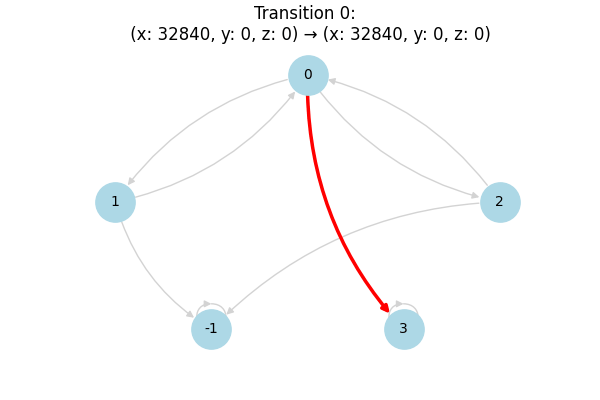

In [13]:
generate_track(declare,init,trans,10)

(pc=0, x=32770_32, y=32769_32, z=0_32)
(pc=2, x=32770_32, y=32769_32, z=0_32)
(pc=0, x=32770_32, y=32768_32, z=32770_32)
(pc=1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)
(pc=-1, x=32770_32, y=32768_32, z=32770_32)


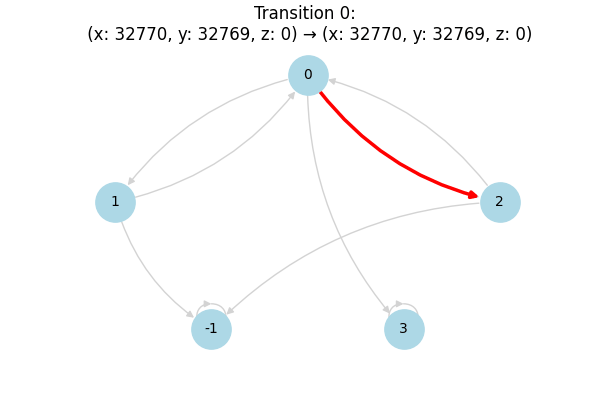

In [14]:
generate_track(declare,init,trans,30)

(pc=0, x=4547_32, y=3_32, z=0_32)
(pc=2, x=4547_32, y=3_32, z=0_32)
(pc=0, x=4547_32, y=2_32, z=4547_32)
(pc=1, x=4547_32, y=2_32, z=4547_32)
(pc=0, x=9094_32, y=1_32, z=4547_32)
(pc=2, x=9094_32, y=1_32, z=4547_32)
(pc=0, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32, z=13641_32)
(pc=3, x=9094_32, y=0_32

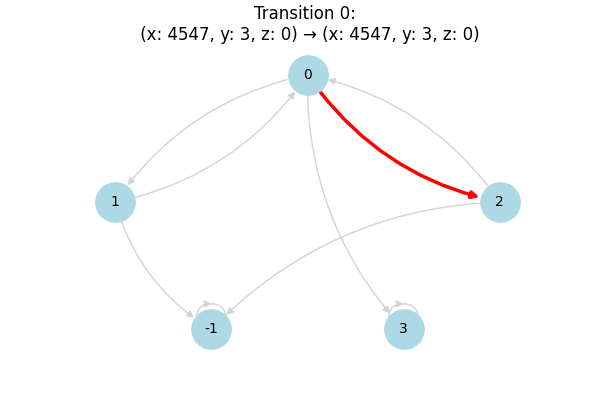

In [15]:
generate_track(declare,init,trans,67)

(pc=0, x=32769_32, y=16385_32, z=0_32)
(pc=2, x=32769_32, y=16385_32, z=0_32)
(pc=0, x=32769_32, y=16384_32, z=32769_32)
(pc=1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
(pc=-1, x=32769_32, y=16384_32, z=32769_32)
Contraexemplo encontrado


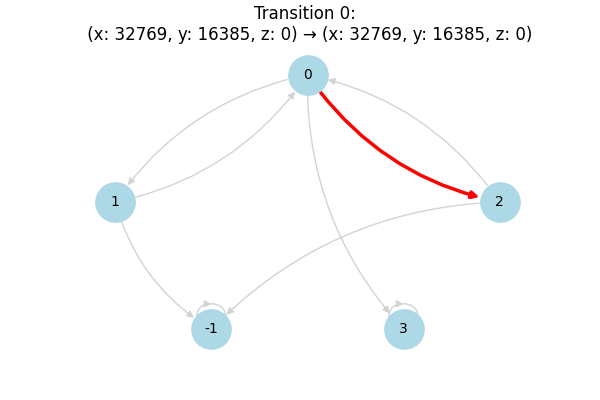

In [16]:
bmc_always_secure(declare,init,trans,error,n,2**n)